<a href="https://colab.research.google.com/github/deondmello16/PubMed200kSolver/blob/main/PubMed200kSolverNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PubMed200kSolverNotebook 📝🔥

## Purpose
The purpose of this notebook is to construct an NLP model aimed at facilitating the comprehension of medical papers.

We will be replicating a paper to utilize its dataset: [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071).

Upon reviewing the aforementioned paper, we discovered that the model architecture used to achieve their outcomes is accessible here: [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/abs/1612.05251).


## Confirm Access to GPU

In [ ]:
!nvidia-smi

Tue Jan  9 10:53:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Getting Dataset

We get this dataset from [Franck-Dernoncourt/pubmed-rct](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [ ]:
# Downloading the dataset

! git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Lets start off our experiment using the 20k dataset with numbers replaced with "@" sign.

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
import os

filenames = [data_dir+'/'+i for i in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocessing data

Now we have text data that has to be processed and passed to the model in form of tensors.

The best way to do it is... Viualize > Visualize > Visualize

Make a function that reads all the lines in target text file.


In [ ]:
# Create a function to read the lines in a document

def get_lines(filename):
  """
  Reads filename (text file) and returns the lines of the text file in form of a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """

  with open(filename,'r') as f:
    return f.readlines()


In [ ]:
## Let's test out our function and just view the first 100 strings

get_lines(data_dir+'/dev.txt')[:100]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

### Making a function to process our data

Lets make a function to pre-process the data thats at hand..

Lets turn this data into a structured format by creating a list of dictionaries..



```
[{
  'line_number':0,
  'target':'BACKGROUND',
   'text': 'Patient adherence to appointments is key to improving outcomes in health care .\n',
   total_lines:11
}]
```



In [ ]:
def preprocess_text_with_line_numbers(filename_path):
  """
    Returns a list of dictionaries of abstract line data.

    Takes in the filename, reads the contents and sorts through the line,
    extracting things like the taget label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number the
    target line is.
  """

  input_line = get_lines(filename_path) # fetch all the lines for the filename specified.
  abstract_lines = "" # create a empty string.
  abstract_samples =[]

  # loop through through each line from input lines

  for line in input_line:
    if line.startswith('###'):
      abstact_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_lines_split = abstract_lines.splitlines()

      for abstrct_line_number, abstact_line in enumerate(abstract_lines_split):
        line_data ={}
        target_text_split = abstact_line.split("\t")
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstrct_line_number
        line_data['total_lines'] = len(abstract_lines_split) -1
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line

  return abstract_samples

In [ ]:
# get the train, dev and test samples
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
dev_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
len(train_samples),len(test_samples),len(dev_samples)

CPU times: user 743 ms, sys: 120 ms, total: 863 ms
Wall time: 1.03 s


(180040, 30135, 30212)

In [ ]:
train_samples[:5],'\n\n',test_samples[:5],'\n\n',dev_samples[:5],

([{'target': 'OBJECTIVE',
   'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
   'line_number': 0,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
   'line_number': 1,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
   'line_number': 2,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
   'line_number': 3,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'secondary outcome measures included 

Now that our data is in the form of list of dictionaries, how about we turn it into a DataFrame to further visualize it...


In [ ]:
import pandas as pd

In [ ]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
dev_df = pd.DataFrame(dev_samples)


In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [ ]:
test_df

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


In [ ]:
dev_df

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9
...,...,...,...,...
30207,RESULTS,pruritus occurred more frequently with the act...,9,13
30208,RESULTS,three patients in the active-regimen group ( @...,10,13
30209,RESULTS,hemoglobin values of grade @ ( @ to < @ g per ...,11,13
30210,CONCLUSIONS,rates of response to a @-week interferon-free ...,12,13


In [ ]:
# Lets view the distributions of the labels

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

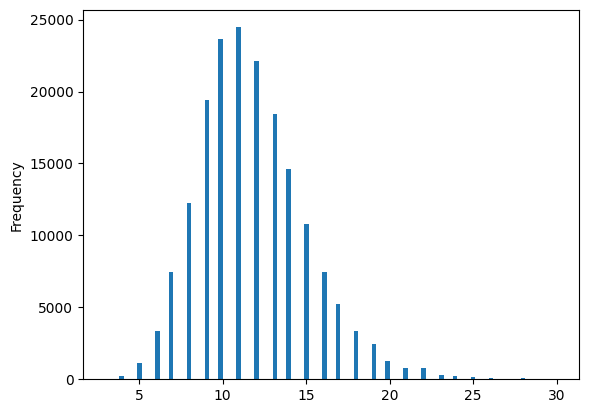

In [ ]:
# Lets view the lengths of deifferent lines

train_df.total_lines.plot.hist(bins=100)

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists

train_sentences = train_df.text.to_list()
val_sentences = dev_df.text.to_list()
test_sentences = test_df.text.to_list()

### Make Numeric labels (ML models require numeric labels)

In [ ]:
# One hot encoding

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(dev_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot,val_labels_one_hot,test_labels_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

### Label Encode labels

In [ ]:
# Extract labels ("target" columns) and Encode them into integers


from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_label_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_label_encoded = label_encoder.transform(dev_df.target.to_numpy())
test_label_encoded = label_encoder.transform(test_df.target.to_numpy())

In [ ]:
# Get class and number of classes from LabelEncoder instance

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,"\n",class_names

(5,
 '\n',
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## The Experiments that we'll be running

Experiments:
1. Naive Bayes with TF-IDF encoder(base-line)
2. Conv1D with token embeddings
3. Tensorflow Hub Pretrained Feature Extractor
4. Conv1D with character Embedding
5. Pretrained Token Embeddings (same as 2) + Character embedding (same as 3)
6. Pretrained token embedding + Character Embeddings + Positional Embedding

### Model_0: Naive Bayes with TF-IDF encoder (base-line model)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("naive_bayes",MultinomialNB())
])

In [ ]:
#Fit the data to the data pipeline created

model_0.fit(X=train_sentences,y=train_label_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()),
                ('naive_bayes', MultinomialNB())])

In [ ]:
# Evaluate the baseline model on validation dataset

model_0.score(
    val_sentences,
    val_label_encoded
)

0.7218323844829869

In [ ]:
y_pred_model_0 = model_0.predict(test_sentences)
y_pred_model_0[:10]

array([2, 2, 2, 4, 4, 4, 4, 1, 4, 0])

In [ ]:
test_label_encoded[:10]

array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0])

In [ ]:
def calculate_performance(y_true,y_pred):

  from sklearn.metrics import accuracy_score,precision_recall_fscore_support

  accuracy = accuracy_score(y_true,y_pred)
  precision,recall,fscore,_ = precision_recall_fscore_support(y_true,y_pred,average='weighted')

  return {
      'accuracy':accuracy*100,
      'precision':precision,
      'recall':recall,


      'f1score':fscore
  }

Lets See the preformance of model_0 and set it as baseline for other models

In [ ]:
model_0_performance = calculate_performance(test_label_encoded,y_pred_model_0)
model_0_performance

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1score': 0.6925101703856846}

### Prepare data for Deep Sequence models (build text vectorizer and embeddings)

##### Create a text vectorization layer

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf

In [ ]:
# Find the average number of word in a tweet
avg_len = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
avg_len

26

In [ ]:
max_vocab_length = 10000
max_tokens = avg_len

In [ ]:
# Create a TextVectorization instance
text_vectorizer = TextVectorization(
    max_tokens = 68000,
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    # ngrams=1,
    output_mode = "int",
    pad_to_max_tokens=True,
    output_sequence_length = 55
)

In [ ]:
# Now fit the TextVectorization instance with the train_sentences

text_vectorizer.adapt(train_sentences)

In [ ]:
text_vectorizer(["patient has high fever "])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 127,  139,  181, 2348,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
import random
random_sentence = random.choice(train_sentences)

print(
    f"Original Sentence:\n{random_sentence}\
    \n\nVectorized Text:\n {text_vectorizer([random_sentence]).shape}"
)

Original Sentence:
women were offered implants among other contraceptive methods , were randomized to daily tdf-ftc or placebo , and followed monthly up to @weeks .    

Vectorized Text:
 (1, 55)


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

##### Create a embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
# create a Embedding instance

embedding = Embedding(
    input_dim = 68000,
    output_dim = 128,
    input_length = 55,
    mask_zero = True
)

In [ ]:
embedding(text_vectorizer(['hello there this is test sentence']))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-4.5110535e-02, -2.4035299e-02,  2.3759674e-02, ...,
         -3.4300111e-02, -2.8824413e-02,  9.7420700e-03],
        [-1.6289018e-02,  1.5625957e-02, -7.2859228e-05, ...,
          4.0597524e-02, -2.5691617e-02,  2.6721943e-02],
        [-2.5035335e-02,  1.5264083e-02, -4.4509090e-02, ...,
          7.5942986e-03,  1.5683983e-02,  2.1233473e-02],
        ...,
        [ 5.6079775e-04, -4.9859967e-02, -1.4661241e-02, ...,
         -4.0273119e-02, -2.9343581e-02,  1.7322931e-02],
        [ 5.6079775e-04, -4.9859967e-02, -1.4661241e-02, ...,
         -4.0273119e-02, -2.9343581e-02,  1.7322931e-02],
        [ 5.6079775e-04, -4.9859967e-02, -1.4661241e-02, ...,
         -4.0273119e-02, -2.9343581e-02,  1.7322931e-02]]], dtype=float32)>

In [ ]:
random_sentence = random.choice(train_sentences)

print(
    f"Original Sentence:\n{random_sentence}\
    \n\nVectorized Text:\n {embedding(text_vectorizer([random_sentence]))}"
)

Original Sentence:
isrctn@ .    

Vectorized Text:
 [[[-0.02350042 -0.03834344 -0.02742521 ... -0.04234331  0.02603854
   -0.01937296]
  [ 0.0005608  -0.04985997 -0.01466124 ... -0.04027312 -0.02934358
    0.01732293]
  [ 0.0005608  -0.04985997 -0.01466124 ... -0.04027312 -0.02934358
    0.01732293]
  ...
  [ 0.0005608  -0.04985997 -0.01466124 ... -0.04027312 -0.02934358
    0.01732293]
  [ 0.0005608  -0.04985997 -0.01466124 ... -0.04027312 -0.02934358
    0.01732293]
  [ 0.0005608  -0.04985997 -0.01466124 ... -0.04027312 -0.02934358
    0.01732293]]]


##### Creating datasets ( making datasets using tf.Data API)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

Creating Prefetch dataset with the help of prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings

In [ ]:
from tensorflow.keras.layers import *

In [ ]:
# Creating 1D conv model to process sequences

input = Input(shape=(1,),dtype = 'string')
x = text_vectorizer(input)
x = embedding(x)
x = Conv1D(64,kernel_size = 5,padding='same',activation='relu')(x)
x = GlobalMaxPooling1D()(x)
output = Dense(num_classes,activation='softmax')(x)

model_1 = tf.keras.Model(input,output,name='model_1')


model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 5)                 325 

In [ ]:
# Fit the model_1

model_1_history = model_1.fit(
    train_dataset,
    steps_per_epoch = int(0.1*len(train_dataset)),
    epochs = 3,
    validation_data = val_dataset,
    validation_steps = int(0.1*len(val_dataset))
)

Epoch 1/3
562/562 [==============================] - 21s 31ms/step - loss: 0.8236 - accuracy: 0.6879 - val_loss: 0.5786 - val_accuracy: 0.7849
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.5737 - accuracy: 0.7876 - val_loss: 0.5371 - val_accuracy: 0.7979
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.5391 - accuracy: 0.8026 - val_loss: 0.5141 - val_accuracy: 0.8138


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5169 - accuracy: 0.8082


[0.5168510675430298, 0.808188796043396]

In [ ]:
model_1_y_pred = model_1.predict(val_dataset)
model_1_y_pred

945/945 [==============================] - 3s 3ms/step


array([[5.4316378e-01, 1.1562560e-01, 1.9422246e-03, 3.3587173e-01,
        3.3966401e-03],
       [3.2390293e-01, 4.7081792e-01, 4.1302750e-04, 2.0336990e-01,
        1.4961555e-03],
       [1.5901834e-01, 1.1446960e-02, 4.4061625e-03, 8.2485574e-01,
        2.7276928e-04],
       ...,
       [1.2338640e-04, 1.5896866e-03, 7.5271046e-03, 4.4104720e-05,
        9.9071574e-01],
       [2.1183942e-02, 5.0514531e-01, 3.8833413e-02, 2.3608619e-02,
        4.1122872e-01],
       [6.6249847e-02, 9.2522675e-01, 1.7231827e-03, 3.1973803e-03,
        3.6028656e-03]], dtype=float32)

In [ ]:
model_1_y_pred = tf.argmax(model_1_y_pred,axis=1)

In [ ]:
model_1_performance = calculate_performance(val_label_encoded,model_1_y_pred)
model_1_performance

{'accuracy': 80.81887991526546,
 'precision': 0.8056059965215407,
 'recall': 0.8081887991526546,
 'f1score': 0.8062510900698618}

### Model 2: Feature extraction with pretrained token embeddings


In [ ]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer(
                                        "https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder"
)



> View the embedded vector generated by the Universal Sentence embedding layer

In [ ]:
random_sentence = random.choice(train_sentences)

print(
    f"Original Sentence:\n{random_sentence}\
    \n\Embedded Text:\n {tf_hub_embedding_layer([random_sentence])}\
    \n\Embedded Shape:\n {tf_hub_embedding_layer([random_sentence]).shape}"
)

Original Sentence:
investigators captured the presence of thrombus on initial angiography and during pci .    
\Embedded Text:
 [[-0.00045166  0.0794263   0.0643784  -0.06897048  0.02748439 -0.06694052
   0.07515647  0.01273225 -0.02579135 -0.03213003  0.07214347 -0.02156431
   0.07630909 -0.03413309  0.05348478 -0.03500277 -0.05772055 -0.00021562
   0.02161131  0.0824028  -0.02236722  0.07818691 -0.02305023  0.00716328
  -0.01775535 -0.01267781 -0.01597561 -0.0192714   0.04926996  0.0018251
  -0.00841735 -0.00536441  0.05311126  0.08538879 -0.06707821  0.00733534
  -0.05933975  0.01306881 -0.01251527 -0.00072341  0.01605805 -0.0419412
   0.03972159 -0.05558212  0.05345516 -0.01851061  0.04528643 -0.02520263
  -0.04073955  0.00617322 -0.06354206 -0.03115999 -0.02846935 -0.0376867
  -0.00108594 -0.01164215 -0.04464989  0.06305298  0.05767443 -0.03816317
  -0.0500746   0.00403787  0.04679062  0.02092386 -0.00228208 -0.02943859
   0.059798    0.01287928  0.03182389 -0.04573857  0.0623499 

##### Building and fitting an NLP feature extraction model from TensorFlow Hub


In [ ]:
## model_2_1

# input = Input(shape=(),dtype='string')
# x = tf_hub_embedding_layer(input)
# x = Dense(128,activation='relu')(x)
# x = Dense(64,activation='relu')(x)
# output = Dense(num_classes,activation='softmax')(x)

## model_2_2

input = Input(shape=(), dtype='string')
x = tf_hub_embedding_layer(input)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Adding dropout
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)  # Adding batch normalization
x = Reshape((-1, 64))(x)  # Assuming 64 is the dimension of the output from the previous layer
x = Bidirectional(LSTM(64))(x)  # Adding bidirectional LSTM
x = Dense(32, activation='relu')(x)  # Adding another dense layer
output = Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(input,output,name='USE_model_2')

model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model_2.summary()

Model: "USE_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                       

In [ ]:
model_2_history = model_2.fit(
    train_dataset,
    steps_per_epoch = int(0.2*len(train_dataset)),
    epochs = 3,
    validation_data = val_dataset,
    validation_steps = int(0.2*len(val_dataset))
)

Epoch 1/3
1125/1125 [==============================] - 33s 20ms/step - loss: 0.8269 - accuracy: 0.6828 - val_loss: 0.7027 - val_accuracy: 0.7348
Epoch 2/3
1125/1125 [==============================] - 23s 21ms/step - loss: 0.7075 - accuracy: 0.7319 - val_loss: 0.6663 - val_accuracy: 0.7436
Epoch 3/3
1125/1125 [==============================] - 20s 18ms/step - loss: 0.6920 - accuracy: 0.7379 - val_loss: 0.6443 - val_accuracy: 0.7564


In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.6467 - accuracy: 0.7566


[0.6467294692993164, 0.7566198706626892]

In [ ]:
model_2_y_pred = tf.argmax(model_2.predict(val_dataset),axis=1)
model_2_y_pred

945/945 [==============================] - 12s 12ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_2_performance = calculate_performance(val_label_encoded,model_2_y_pred)
model_2_performance

{'accuracy': 75.66198861379584,
 'precision': 0.7534033520277639,
 'recall': 0.7566198861379584,
 'f1score': 0.7531415381626018}

### Model 3: Conv1D with Character Embedding



#### Let's create a character level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into individual characters

def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# Split sequence level data into character level data split

train_chars = [split_chars(sentences) for sentences in train_sentences]
val_chars = [split_chars(sentences) for sentences in val_sentences]
test_chars = [split_chars(sentences) for sentences in test_sentences]

train_chars[:5],test_chars[:5],val_chars[:5],

(['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
  'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
  'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s  

In [ ]:
## what's the average character length
import numpy as np

char_lens = [len(sentence) for sentence in train_sentences]

mean_char_lens = np.mean(char_lens)

mean_char_lens

149.3662574983337

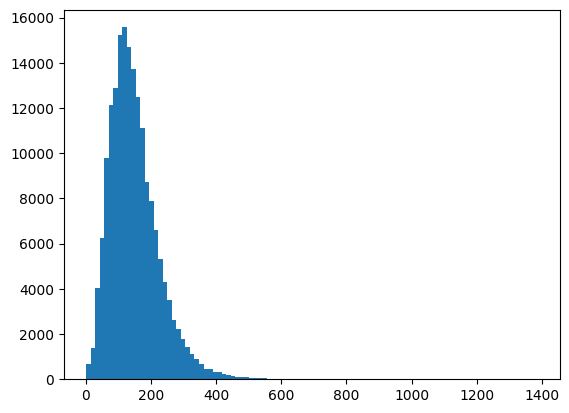

In [ ]:
# Check the distribution of the sequences at character level

import matplotlib.pyplot as plt

plt.hist(char_lens,bins=100,);

In [ ]:
# lets figure out what chat character length covers 95% of the sequences

output_sequence_char_length = int(np.percentile(char_lens,95))
output_sequence_char_length

290

In [ ]:
#get all the keyboard level charcter

import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet,len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
NUMS_CHAR_TOKENS = len(alphabet) + 2 # one for space and other is for <OOV> (out of vocab)

char_vectorizer = TextVectorization(
                                  max_tokens = NUMS_CHAR_TOKENS,
                                  output_sequence_length = output_sequence_char_length,
                                  standardize=None,
                                  name = 'char_vectorizer'
)

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vectorizer(val_chars[:1])

<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[ 4, 18,  2,  9,  2,  6,  9,  4,  3,  4, 32,  5,  3,  4,  7,  6,
         3,  7,  5,  9, 14,  2,  8, 18,  4, 12, 12, 16,  9, 17, 16, 15,
         4, 18,  5,  3, 16,  9,  5,  6, 10,  5, 14,  7,  9,  4,  3,  4,
        22,  2,  9, 14, 16,  3, 16, 15, 17, 16,  6, 18,  5, 12, 11, 16,
        12,  3, 16,  8,  2,  8,  2,  9, 16, 12,  3,  5,  8,  2, 11,  7,
        15, 15,  7,  6,  4,  6, 14,  5,  3,  4,  2,  6,  3,  9, 21,  4,
         3, 13,  8,  2, 17,  8,  5, 11,  3,  7,  8, 20,  5,  9,  3, 13,
        15,  5, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

In [ ]:
# lets see the 10 most common characters in the train_chars

char_vectorizer.get_vocabulary()[:10],len(char_vectorizer.get_vocabulary())

(['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's'], 57)

In [ ]:
random_train_char = random.choice(train_chars)

print(f"Charified Text:\n{random_train_char}")
print(f"Length of random train_sentence:\n{len(random_train_char.split())}")

vectorized_char = char_vectorizer([random_train_char])

# print(f")

vectorized_char,vectorized_char.shape,

Charified Text:
c y a   +   p r e d n i s o l o n e   w a s   c o n t i n u e d   f o r   @   w e e k s   .
Length of random train_sentence:
38


(<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
 array([[11, 20,  5, 41, 14,  8,  2, 10,  6,  4,  9,  7, 12,  7,  6,  2,
         21,  5,  9, 11,  7,  6,  3,  4,  6, 16,  2, 10, 17,  7,  8, 19,
         21,  2,  2, 29,  9, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  

#### Let's create a character level embedding

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()

In [ ]:
char_embedding = Embedding(
    input_dim = len(char_vocab),
    output_dim = 25, # this is the size of the char embedding in the paper
    sparse = False,
    mask_zero = True
)

In [ ]:
# Lets see the output thats generated from the embedding layer

char_embedding(vectorized_char).shape

TensorShape([1, 290, 25])

#### Build Model 3: Build, fit and evaluate a Conv1D model on character level embedding

In [ ]:
from tensorflow.keras import layers

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
print(char_embeddings.shape)
# char_embeddings_reshaped = layers.Reshape((290, 25))(char_embeddings)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

(None, 290, 25)


In [ ]:
model_3.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           1425      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 5

In [ ]:
train_chars[10]

't h e   o u t c o m e   m e a s u r e s   i n   r h e u m a t o l o g y   c l i n i c a l   t r i a l s - o s t e o a r t h r i t i s   r e s e a r c h   s o c i e t y   i n t e r n a t i o n a l   r e s p o n d e r   r a t e   w a s   @   %   i n   t h e   i n t e r v e n t i o n   g r o u p   a n d   @   %   i n   t h e   p l a c e b o   g r o u p   (   p   <   @   )   .'

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset,val_char_dataset,test_char_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.1656 - accuracy: 0.5381 - val_loss: 0.9446 - val_accuracy: 0.6293
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9100 - accuracy: 0.6361 - val_loss: 0.8605 - val_accuracy: 0.6639
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.8377 - accuracy: 0.6733 - val_loss: 0.7949 - val_accuracy: 0.6945


In [ ]:
## Make predictions with our model

model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8031 - accuracy: 0.6888


[0.8030548691749573, 0.6887660622596741]

In [ ]:
model_3_y_pred = tf.argmax(model_3.predict(val_char_dataset),axis=1)
model_3_y_pred

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [ ]:
model_3_performance = calculate_performance(val_label_encoded,model_3_y_pred)

In [ ]:
model_3_performance

{'accuracy': 68.87660532238846,
 'precision': 0.6912680234582743,
 'recall': 0.6887660532238845,
 'f1score': 0.6805067452464184}

In conclusion model_3 happens to be the worst model we have trained yet

### Model 4: Pretrained Token-embeddings + Character embeddings (hybrid embedding layer)

##### Steps:

1. Create a token-level embedding model (similar to `model_1`)
2. Create a Character-level embedding model (similar to `model_3`)
3. Combine 1 & 2 with a concatenate (`layers.concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [PubMed 200k RCT](https://arxiv.org/pdf/1710.06071.pdf).
5. Construct a model which takes token and character-level sequences as input and produces sequence label probablities as outputs


In [ ]:
# Step 1: Setup a token inputs/model

token_input = Input(shape=(),dtype=tf.string,name='token_input')
token_embedding_layer = tf_hub_embedding_layer(token_input)
token_output = Dense(128,activation='relu')(token_embedding_layer)
token_model = tf.keras.Model(token_input,
                             token_output,
                             name='char_embeddings_output')

# Step 2: Setup a charcter inputs/model

char_inputs = Input(shape=(1,),dtype=tf.string,name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = Bidirectional(LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm,
                            name='char_embeddings_output')

# Step 3. Concatenate token and Char inputs (create a hybrid token embedding)

token_char_concat = Concatenate(name="token_char_hybrid")([token_model.output,
                                                           char_model.output])

# Step 4. Create output layers - adding in Dropout, as discuessed in the paper (section 4.2)

combine_dropout = Dropout(0.5)(token_char_concat)
combined_dense = Dense(128,activation='relu')(combine_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(num_classes,activation='softmax')(final_dropout)

# Step 5: Construct model with char and token inputs

model_4 = tf.keras.Model(inputs = [token_input,char_inputs],
                         outputs = output_layer,
                         name='model_4_token_and_char_embeddings')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

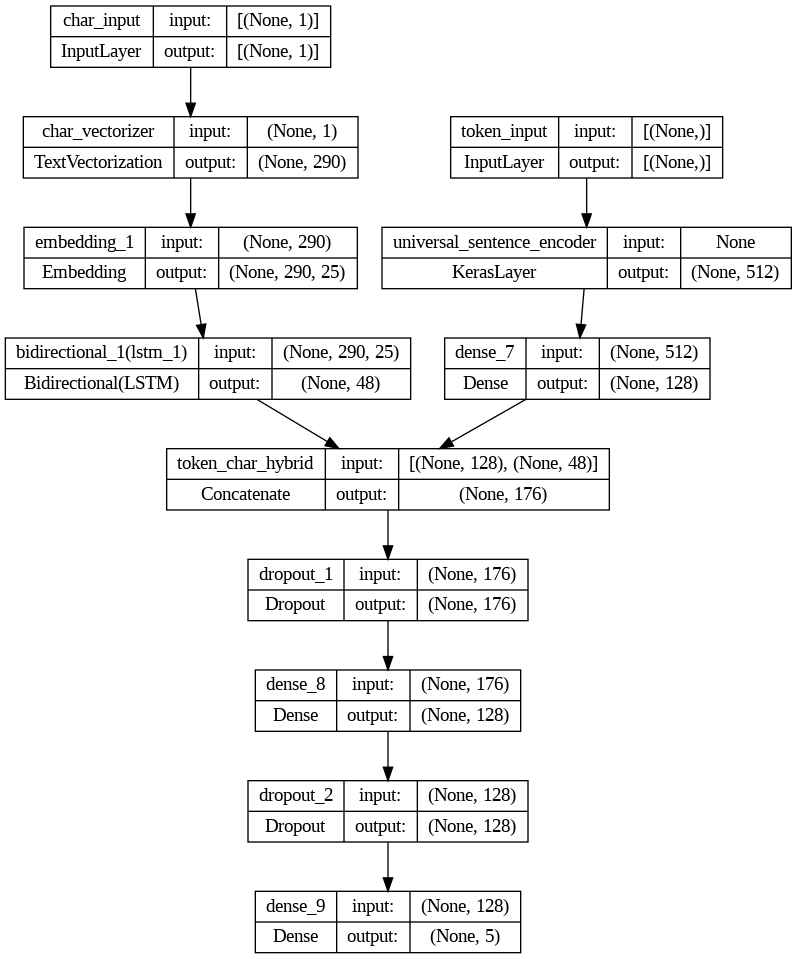

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming you've created your model, model_4
plot_model(model_4, to_file='model_4.png', show_shapes=True)


In [ ]:
model_4.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

#### Combining token and character data into a tf.data Datasets


In [ ]:
# Combine chars and tokens into a dataset

train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))

train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data,train_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))

val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data,val_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))

test_char_token_dataset = tf.data.Dataset.zip((test_token_char_data,test_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Fitting the prefect dataset (token and character level embedding)


In [ ]:
# Fit the model on tokens and chars

model_4_history = model_4.fit(
    train_char_token_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1*len(train_char_token_dataset)),
    validation_data = val_char_token_dataset,
    validation_steps = int(0.1*len(val_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 37s 46ms/step - loss: 0.9678 - accuracy: 0.6147 - val_loss: 0.7606 - val_accuracy: 0.7108
Epoch 2/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7923 - accuracy: 0.6956 - val_loss: 0.7175 - val_accuracy: 0.7244
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7689 - accuracy: 0.7084 - val_loss: 0.6937 - val_accuracy: 0.7390


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6942 - accuracy: 0.7367


[0.6942487955093384, 0.7366609573364258]

In [ ]:
model_4_y_pred = tf.argmax(model_4.predict(val_char_token_dataset),axis=1)
model_4_y_pred

945/945 [==============================] - 21s 19ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_performance = calculate_performance(val_label_encoded,model_4_y_pred)

In [ ]:
model_4_performance

{'accuracy': 73.66609294320138,
 'precision': 0.739339138880861,
 'recall': 0.7366609294320138,
 'f1score': 0.7355415377353646}

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

#### Feature Engineering

* Taking **non-obvious features** from the data and encodong them numerically to help our model is called **feature engineering**.


In [ ]:
# Let's see the dataframe that we created in the begining of the notebook
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

#### Creating Positional Embeddings

##### Line number

In [ ]:
## Lets see how many different line numbers are there

line_nums_dist = train_df['line_number'].value_counts()
line_nums_dist

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

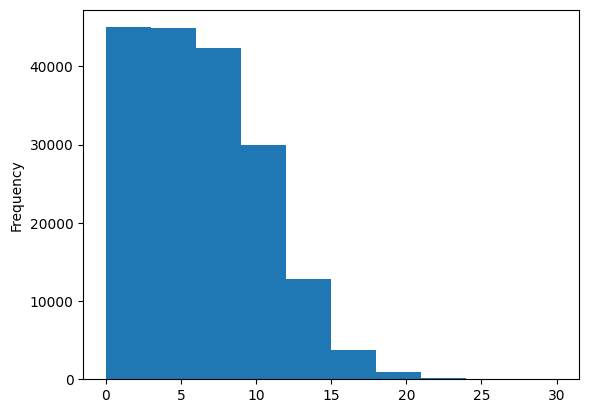

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
## Lets see which is the ideal line number that covers 95% of the data

line_num_95_per = int(np.percentile(train_df.line_number.to_list(),95))
line_num_95_per

13

In [ ]:
# Using Tensorflow's one-hot encoded tensor of our "line_number"

## from the above cell its clear that **13** cover 95 percent of the data but, just be on the safer side lets make it **15**

train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(dev_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

train_line_numbers_one_hot[:5],val_line_numbers_one_hot[:5],test_line_numbers_one_hot[:5]

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0

##### Total Number of lines

In [ ]:
train_df["total_lines"][:100]

0     11
1     11
2     11
3     11
4     11
      ..
95    10
96    10
97    10
98    10
99    10
Name: total_lines, Length: 100, dtype: int64

<Axes: ylabel='Frequency'>

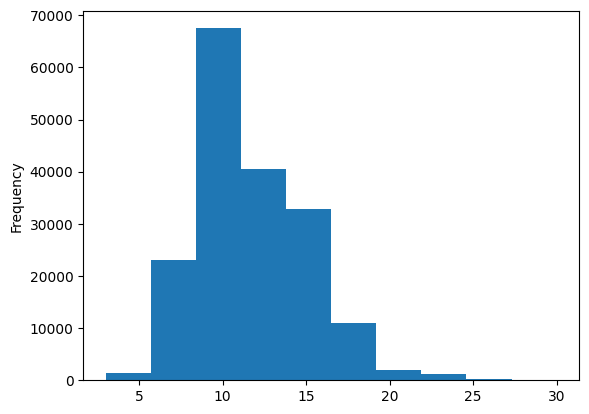

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
## Lets see the percentiles

total_lines_95_per = int(np.percentile(train_df.total_lines.to_numpy(),95))
total_lines_95_per

18

In [ ]:
## from the above cell we see **18** would be a appropriate depth for one_hot encodeing but just to be on the safer side lets make it 20

train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(),depth=18)
val_total_lines_one_hot = tf.one_hot(dev_df.total_lines.to_numpy(),depth=18)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(),depth=18)
train_total_lines_one_hot[:5],val_total_lines_one_hot[:5],test_total_lines_one_hot[:5]

(<tf.Tensor: shape=(5, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(5, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.

In [ ]:
# Just to check the data generated it correct
# list(tf.argmax(total_lines_one_hot[:10],axis=1)) == train_df.total_lines[:10].to_list()

#### Building the tribrid model

##### Steps to build **Tribrid Model**:

1. Create a token-level model
2. Create a character[link text](https://)-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the output of 1 & 2 using the `tf.keras.layers.Concatenate`
6. Combine the output of 3, 4 & 5 using the `tf.keras.layers.Concatenate`
7. Create a output layer to accept the tribrid embedding and output label probablities
8. Combine the inputs of 1, 2, 3 & 4 and outputs into a `tf.keras.Model`



In [ ]:
# 1. Token inputs/model

token_inputs = Input(shape=(),dtype=tf.string,name="token_level_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(
                            inputs = token_inputs,
                            outputs = token_outputs,
                            name="token_level_model"
)

# 2. Create a character-level model

character_input = Input(shape=(1,),dtype=tf.string,name="charcter_level_input")
character_vectors = char_vectorizer(character_input)
character_embed = char_embedding(character_vectors)
char_bi_lstm = Bidirectional(LSTM(32))(character_embed)
character_model = tf.keras.Model(
                                  inputs = character_input,
                                  outputs = char_bi_lstm,
                                  name = "character_level_model"
)

# 3. Create a model for `line_number` feature

line_num_input = Input(shape=(15,),dtype = tf.int32,name="line_number_input")
x = Dense(32,activation='relu')(line_num_input)
line_number_model = tf.keras.Model(
                                    inputs = line_num_input,
                                    outputs = x,
                                    name = "line_number_model"
)

# 4. Create a model for `total_line` feature

total_line_input = Input(shape=(18,),dtype=tf.int32,name='total_line_input')
x = Dense(32,activation='relu')(total_line_input)
total_lines_model = tf.keras.Model(
                                    inputs = total_line_input,
                                    outputs = x ,
                                    name = "total_lines_model"
)

# 5. Combine the output of 1 & 2 using the `tf.keras.layers.Concatenate`

token_char_concat_layer = Concatenate(name = "token_char_concatenate_layer")([token_model.output,character_model.output])

z = Dense(256,activation='relu')(token_char_concat_layer)
z = Dropout(0.5)(z)

# 6. Combine the output of 3, 4 & 5 using the `tf.keras.layers.Concatenate`

z = Concatenate(name="token_char_line-num_total-lines_layer")([line_number_model.output,
                                                               total_lines_model.output,
                                                               z])

output_layer = Dense(5,activation='softmax',name='final_output_layer')(z)

model_5 = tf.keras.Model(inputs=[token_inputs,
                                 character_input,
                                 line_num_input,
                                 total_line_input],
                                 outputs = output_layer,
                                 name = "model_5"
                                 )

model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 charcter_level_input (Inpu  [(None, 1)]                  0         []                            
 tLayer)                                                                                          
                                                                                                  
 token_level_input (InputLa  [(None,)]                    0         []                            
 yer)                                                                                             
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['charcter_level_input[0][0]']
 rization)                                                                                  

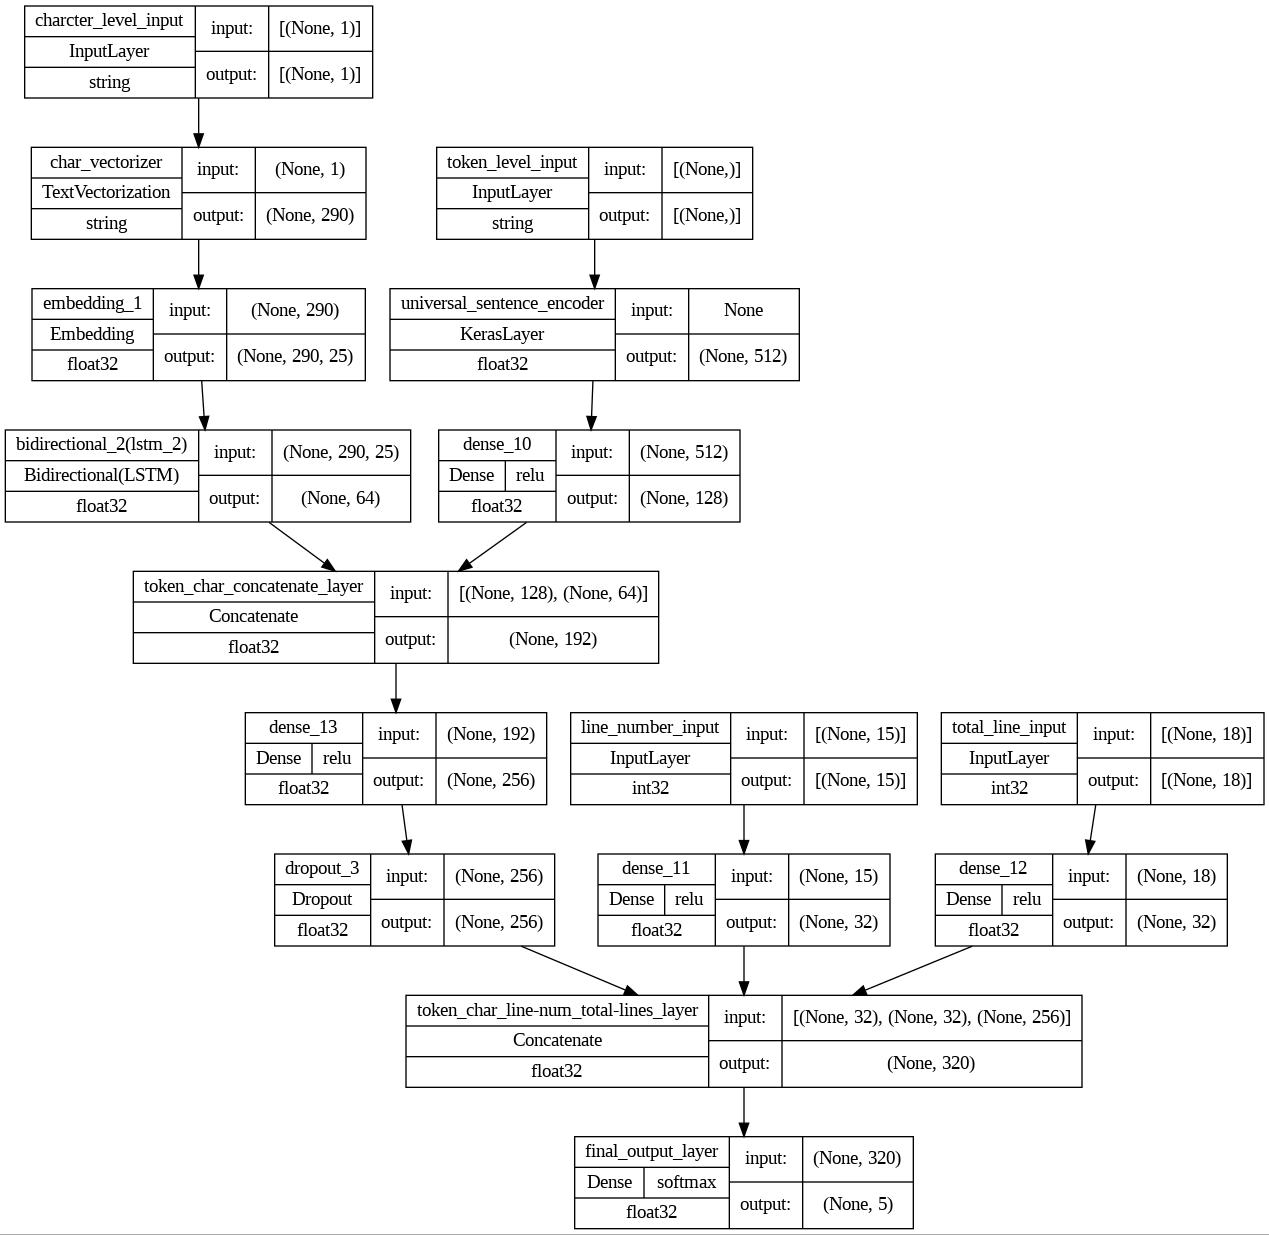

In [ ]:
plot_model(model_5,to_file="model_5.jpeg",show_shapes=True,show_layer_names=True,show_dtype=True,show_layer_activations=True)

In [ ]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

#### Creating Datasets for our tribrid model (model_5)


In [ ]:
train_token_char_num_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                                     train_chars,
                                                                     train_line_numbers_one_hot,
                                                                     train_total_lines_one_hot))
train_token_char_num_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_token_char_num_pos_dataset = tf.data.Dataset.zip((train_token_char_num_pos_data,train_token_char_num_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)



val_token_char_num_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                                     val_chars,
                                                                     val_line_numbers_one_hot,
                                                                     val_total_lines_one_hot))
val_token_char_num_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_token_char_num_pos_dataset = tf.data.Dataset.zip((val_token_char_num_pos_data,val_token_char_num_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


test_token_char_num_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences,
                                                                     test_chars,
                                                                     test_line_numbers_one_hot,
                                                                     test_total_lines_one_hot))
test_token_char_num_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_token_char_num_pos_dataset = tf.data.Dataset.zip((test_token_char_num_pos_data,test_token_char_num_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)




In [ ]:
train_token_char_num_pos_dataset,val_token_char_num_pos_dataset,test_token_char_num_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
len(train_token_char_num_pos_dataset)*32

180064

#### Fitting, evaluate and making predictions with the **tribrid model**

##### Fitting the data in **model_5**

In [ ]:
model_5_history = model_5.fit(train_token_char_num_pos_dataset,
            epochs=3,
            steps_per_epoch = int(0.1*len(train_token_char_num_pos_dataset)),
            validation_data = val_token_char_num_pos_dataset,
            validation_steps = int(0.1*len(test_token_char_num_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 50ms/step - loss: 1.0864 - accuracy: 0.7283 - val_loss: 0.9762 - val_accuracy: 0.8102
Epoch 2/3
562/562 [==============================] - 23s 40ms/step - loss: 0.9611 - accuracy: 0.8195 - val_loss: 0.9447 - val_accuracy: 0.8331
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9419 - accuracy: 0.8285 - val_loss: 0.9320 - val_accuracy: 0.8428


##### Evaluate **model_5**

In [ ]:
model_5.evaluate(val_token_char_num_pos_dataset)

945/945 [==============================] - 19s 21ms/step - loss: 0.9274 - accuracy: 0.8422


[0.9273979663848877, 0.8422150015830994]

In [ ]:
model_5_pred = model_5.predict(val_token_char_num_pos_dataset)
model_5_pred

945/945 [==============================] - 20s 18ms/step


array([[0.50701976, 0.12374458, 0.01171495, 0.34044382, 0.01707687],
       [0.53328043, 0.1084121 , 0.04316558, 0.30359894, 0.01154298],
       [0.2914824 , 0.12515184, 0.10934089, 0.41206706, 0.06195772],
       ...,
       [0.04460422, 0.12271184, 0.04745724, 0.03781415, 0.74741256],
       [0.03096192, 0.3314814 , 0.09092646, 0.02394886, 0.52268136],
       [0.17980306, 0.57716906, 0.12560554, 0.04337797, 0.07404438]],
      dtype=float32)

In [ ]:
model_5_pred = tf.argmax(model_5_pred,axis=1)
model_5_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_performance = calculate_performance(val_label_encoded,model_5_pred)
model_5_performance

{'accuracy': 84.22150139017609,
 'precision': 0.8414058115185374,
 'recall': 0.8422150139017609,
 'f1score': 0.8411965912412199}

## Let's evaluate all the models that have been built

In [ ]:
# Combine all the models' performance/results into a DataFrame

import pandas as pd

all_model_results = pd.DataFrame({"baseline": model_0_performance,
                                  "custom_token_embed_conv1d": model_1_performance,
                                  "pretrained_token_embed": model_2_performance,
                                  "custom_char_embed_conv1d": model_3_performance,
                                  "hybrid_char_token_embed": model_4_performance,
                                  "tribrid_token_char_num_pos_embed": model_5_performance})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1score
baseline,71.667496,0.712432,0.716675,0.692510
custom_token_embed_conv1d,80.818880,0.805606,0.808189,0.806251
pretrained_token_embed,75.661989,0.753403,0.756620,0.753142
custom_char_embed_conv1d,68.876605,0.691268,0.688766,0.680507
hybrid_char_token_embed,73.666093,0.739339,0.736661,0.735542
tribrid_pos_char_token_embed,84.221501,0.841406,0.842215,0.841197


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

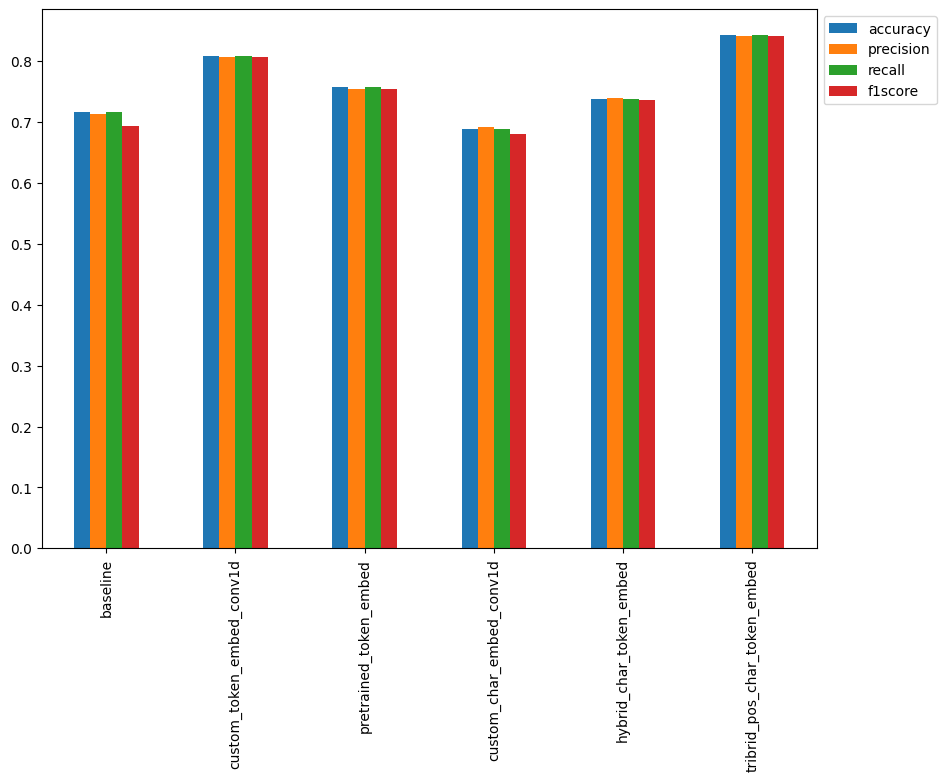

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

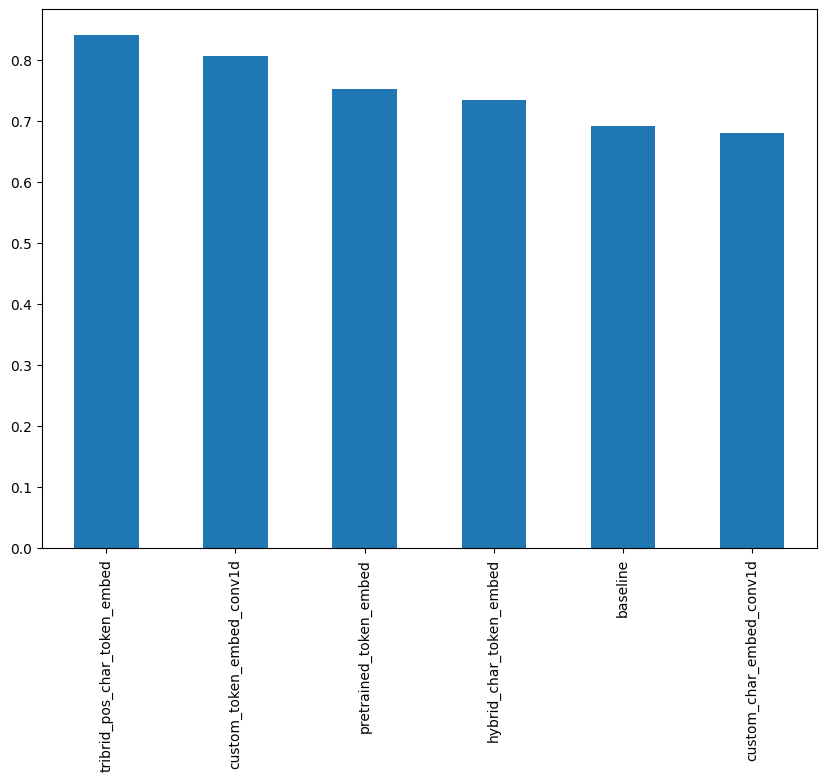

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1score", ascending=False)["f1score"].plot(kind="bar", figsize=(10, 7));


## Save and load best performing model

Save model in default format

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("PubMed200k_tribrid_model")

Mount Gdrive

In [ ]:
from google.colab import drive

drive.mount('/content/Drive')


Mounted at /content/Drive


Copy model to Gdrive

In [ ]:
!cp PubMed200k_tribrid_model/ -r /content/Drive/MyDrive/Colab\ Notebooks/

## Conclusion

Through a series of diverse modeling experiments conducted on the PubMed20k dataset, it is evident that there exists substantial potential for further enhancement. The current frontrunner, `tribrid_token_char_num_pos_embed`, attaining an accuracy of 83%, has been trained on only 10% of the dataset. It is highly probable that its performance will exhibit marked improvement when trained on the entire PubMed20k corpus.

This notebook serves as an ongoing project, poised for continuous advancement. It will continuously evolve by integrating and implementing methodologies observed in analogous models. The pursuit of refining and optimizing the model's performance remains an ongoing objective.

Thank you.
